***Note: this is the Phosphorylation.ipynb notebook. The
PDF version is available [here](Phosphorylation.pdf).***



# Introduction
The Mitogen-activated Protein Kinase (MAPK) cascade is a well-studied
signalling pathway with ultrasensitive components 
<cite data-cite="AlbJohLew15,KliLieWie16"></cite>. However, the use of the  Michaelis-Menten
approximation to enzyme-catalysed reactions can be misleading in this
context <cite data-cite='Voi13'></cite>.

Following <cite data-cite="GawCra16"></cite>, each phosphorylation step is built out of
reversible mass-action reactions using the bond graph approach of
<cite data-cite="GawCra14"></cite>. This resolves the potential problems
mentioned above as well as giving a thermodynamically compliant model
which explicitly accounts for energy consumption via ATP hydrolysis.

This notebook presents, analyses and simulates three bond graph models
using [BondGraphTools](https://pypi.org/project/BondGraphTools/) and extensions:

1. A phosphorylation/dephosphorylation system (PD).

2. A double phosphorylation/dephosphorylation system (DPD).

3. A Mitogen-activated Protein Kinase (MAPK)
   cascade using a cascade of one PD systems and two DPD systems.


## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Modular bond graphs
import modularBondGraph as mbg

## Export stoichiometry as bond graph
import stoichBondGraph as stbg

## Data structure copy
import copy

## Set quiet=False for verbose output
quiet = True

# Phosphorylation/dephosphorylation
A biomolecular cycle involving both phosphorylation and
dephosphorylation is a basic element of cell signalling
<cite data-cite="AlbJohLew15"></cite>. A bond graph model of this cycle
<cite data-cite="GawCra14,GawCra16"></cite> is given in the Figure.

1. The upper part of the   bond graph  represents an enzyme-catalysed
reaction phosphorylating protein M to give MP driven by the
dephosphorylation of ATP to ADP.

2. The lower part of the bond graph  represents an enzyme-catalysed
reaction dephosphorylating protein MP to give M and P.

This forms a biochemical switch <cite data-cite="BeaQia10"></cite> with input the net
amount of E1 and C1 and output the  phosphorylated protein MP. 

## Convert bond graph in SVG format to BGT format and display

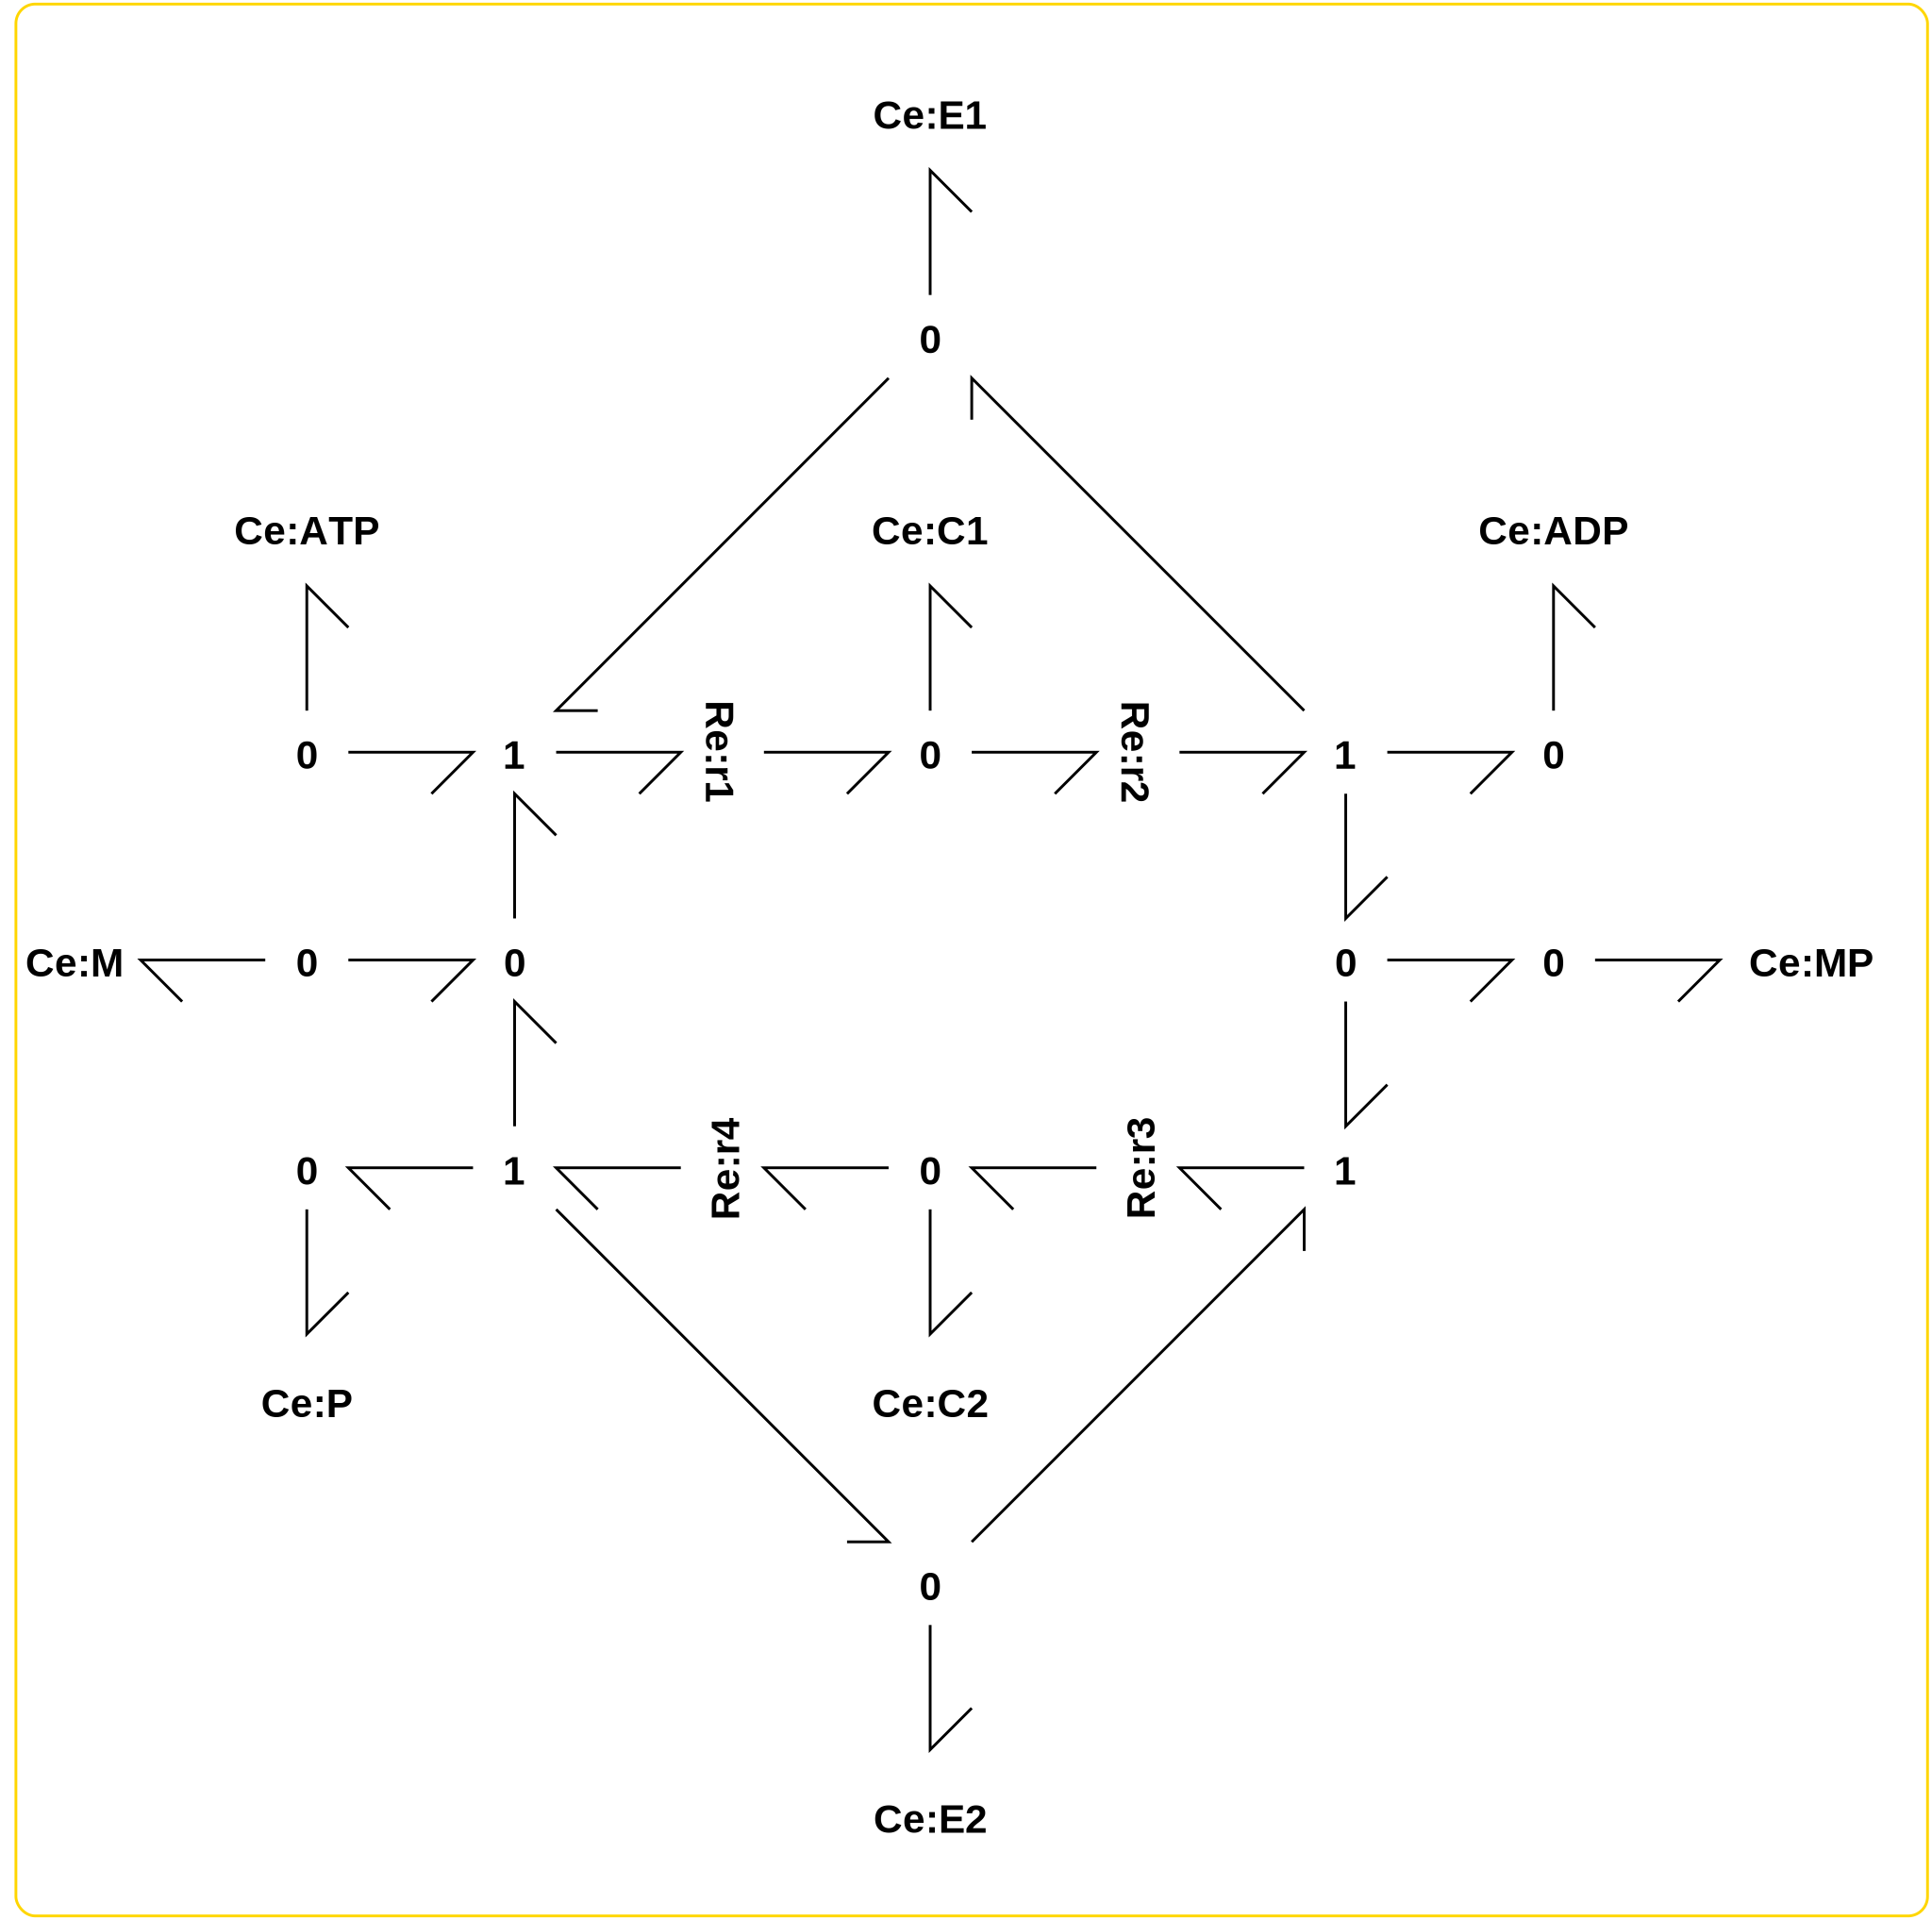

In [2]:
## Phosphorylation/dephosphorylation
sbg.model('PD_abg.svg',quiet=quiet)
import PD_abg
disp.SVG('PD_abg.svg')

## A flowstat is used to add to the pool of enzyme formed by E1 and C1

The flowstat is formed from a simple reaction A$\Leftrightarrow$B where A is a chemostat and B is unified with E1. The flow in this reaction is set in the simulation.

In [3]:
def addFlowstat(model,species,quiet=False):
    
    ## Creat a simple reaction
    sbg.model('AB_abg.svg',quiet=quiet)
    import AB_abg
    AB = AB_abg.model()
    mbg.rename(AB,{'A':'Aflow','B':species},quiet=quiet)
    
    ## Create composite model
    modelF = bgt.new(name='modelF')
    modelF.add(model,AB)
    mbg.unify(modelF,[species],quiet=quiet)
    
    return modelF
    
PDF = addFlowstat(PD_abg.model(),'E1',quiet=quiet)

## Reactions, pathways and pools
The coresponding reactions and pathways are generated using stoich.

1. The four reactions r1-r4 correspond to the four Re components in the
bond graph.

2. The reaction r corresponds to the added flowstat: the flow in r is
externally specified and provides a way to change the amount of enzyme
in the E1/P1 pool.

3. There is a single pathway though the four components r1-r4
corresponding the the flow around the loop driven by the reaction
ATP = ADP + P.

4. The two enzyme catalysed reactions are modulated by {E1} and
E2 which therfore determine the flows and the relative amounts of
M and MP.

5. Apart from the chemostats which are themselves conserved moieties, there are two pools:

    a) C2 + E2 
    
    b) C1 + C2 + M + MP
    
   Note that C1+E1 is not a pool due to the input flow from the flowstat.

### Reactions

In [4]:
s = st.stoich(PDF,quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

### Pathways
The ATP hydrolysis species are set as chemostats together with Aflow from the flowstat reaction

In [5]:
chemostats = ['Aflow','ATP','ADP','P']
sc = st.statify(s,chemostats=chemostats)
print(st.sprintp(sc))

1 pathways
0:  + r1 + r2 + r3 + r4



In [6]:
sp = st.path(s,sc)
disp.Latex(st.sprintrl(sp))

<IPython.core.display.Latex object>

### Pools: Conserved moieties

In [7]:
disp.Latex(st.sprintml(sc,chemformula=True))

<IPython.core.display.Latex object>

## Set up parameters for PD

In [8]:
def setParameterPD(s,x_M=1,x_E2=0.1):
    """Set up parameters and states for simulation of PD module"""
    
    parameter = {}
    
    # Ce components: set non-unity parameters
    K_ATP = 1e2
    K_ADP = 1e-3
    K_P = 1e-3
    parameter['K_ATP'] = K_ATP
    parameter['K_ADP'] = K_ADP
    parameter['K_P'] = K_P
    parameter['K_E1'] = 1
    parameter['K_E2'] = 1
    parameter['K_C1'] = 100
    parameter['K_C2'] = 100
 
    ## Initial states
    small = 1e-10
    
    ## Small initial values
    smallStates = ['E1','C1','C2','MP']
    for smallState in smallStates:
        parameter['X0_'+smallState] = small
    
    ## Initial values of other states
    parameter['X0_M'] = x_M
    parameter['X0_E2'] = x_E2  
    
    return parameter

### Plotting

In [9]:
def inPool(s,X,species):
    """Find total amount in pool specified by species"""
    
    index = []
    for spec in species:
        index.append(s['species'].index(spec))
        
    total = np.sum(X[:,index],axis=1)

    return total

def Plot(s,dat,M=['M','MP'],E=['E1','C1'],i0=0):
    """Plot relevant data"""
    
    ## Extract data
    X = dat['X']
    V = dat['V']
    N = s['N']
    dX = (N@V.T).T
    dX_ATP = dX[:,s['spec_index']['ATP']]
    dX_ADP = dX[:,s['spec_index']['ADP']]
    dX_P = dX[:,s['spec_index']['P']]


    st.plot(s,dat,species=M,reaction = [],i0=10)


    plt.plot(t,dX_ATP,t,dX_ADP,t,dX_P)
    plt.grid()
    plt.ylabel('Flow $v$')
    plt.xlabel('$t$')
    plt.legend(['ATP','ADP','P'])
    plt.show()
    
    e_tot = inPool(s,X,E)
    
    plt.plot(t,e_tot)
    plt.grid()
    plt.xlabel('$t$')
    plt.show()
    
    st.plot(s,dat,species=M,reaction = [],x=e_tot,xlabel='$e_{tot}$',i0=10)

## Simulation

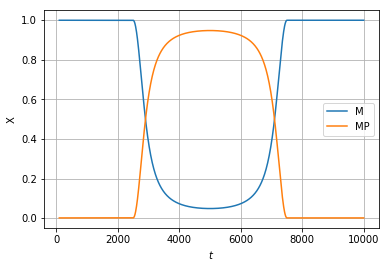

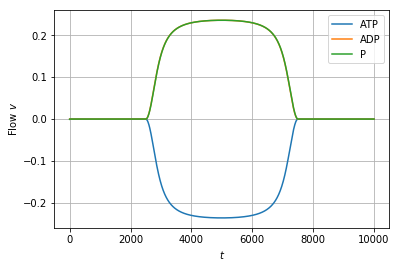

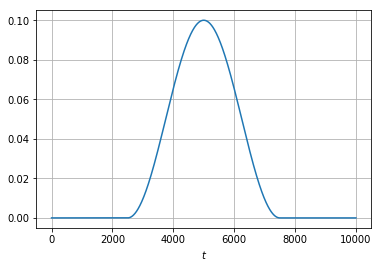

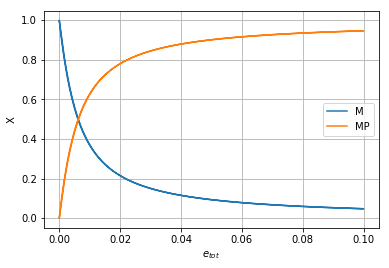

In [10]:
def setFlow(e_max,t_max):
    """Set the flow stat flow (as a string)
    
    Flow is non-zero between 0.25 and 0.75 t_max
    and is sinusoidal. 
    The integrated flow has a maximum at e_tot = e_max
    
    """
    r_flow = ('2*{0}*( (t>(0.25*{1}))*(t<(0.75*{1})) )'
              '*np.sin(4*np.pi*(t-0.25*{1})/{1})'
                .format(np.pi*e_max/(t_max),t_max)
              )
    V_flow = {'r':r_flow}
    
    return V_flow
    
    
##Time
quiet = True
#t_max = int(8e2)
t_max = 1e4
t = np.linspace(0,t_max,1000)
t_0 = 100
t_1 = t_max-t_0
i_max = len(t)
i_0 = int(i_max*t_0/t_max)
i_1 = i_max-i_0

## Flow
x_M = 1
e_max = 1e-1
V_flow = setFlow(e_max,t_max)

## Parameters
x_E2=0.5*x_M
parameter = setParameterPD(s,x_M=x_M,x_E2=x_E2)

## Simulate
dat = st.sim(s,sc=sc,t=t,parameter=parameter,V_flow=V_flow,quiet=quiet)

## Plot
Plot(s,dat,M=['M','MP'],E=['E1','C1'])


## Discussion
The PD module acts and a high-gain saturating amplifier, or switch <cite data-cite="BeaQia10"></cite>, with the total  enzyme  associated with the first reaction $e_{tot}= x_{E1}+x_{c1}$ as the input and the amount of the phosphorylated protein MP as output. Note that $e_{tot}$ is varied using the flowstat.

# Double Phosphorylation/dephosphorylation
Double phosphorylation/dephosphorylation is an important building block of signalling cascades
<cite data-cite="AlbJohLew15,KliLieWie16"></cite>. A model can be built by combining two copes of the PD module using [BondGraphTools](https://pypi.org/project/BondGraphTools/) <cite data-cite="CudGawPanCra19X"></cite>.

## Set up parameters for DPD

In [11]:
def copyNames(names,same=[],changed={},prefix=''):
    
    rename = {}
    for name in names:
        if not name in same:
            if name in changed.keys():
                rename[name] = changed[name]
            else:
                rename[name] = prefix+name

    return rename

def copyParameters(parameter,rename):
    
    sep = '_' # parameter seperator
    Parameter = {}
    for key,val in parameter.items():
        Key = key.split(sep)
        #print(key,Key)
        if len(Key)<2:
            print(key,'should contain _')
        else:
            prefix = Key[0]
            name = Key[1]
            for nam in Key[2:]:
                name += sep+nam
            
        if name not in rename.keys():
            Parameter[key] = val
        else:
            Parameter[prefix+sep+rename[name]] = val
    return Parameter

def mergeParameters(par1,par2):

#    par = par1.copy()
    par = {}
    for key,val in par2.items():
        par[key] = val
    for key,val in par1.items():
        par[key] = val
    return par


## Create DPD from two copies of PD

In [12]:
def makeDPD(x_M=x_M,x_E2=x_E2,quiet=False):
    """Create Double Phosphorylation/dephosphorylation"""
    
    
    ## Components not to be renamed
    same = ['E1','ATP','ADP','P']
    
    ## Common components to be unified
    unified = same + ['MP']
    
    ## Create two copies of PD, renaming as appropriate
    PD1 = PD_abg.model()
    sPD = st.stoich(PD_abg.model(),quiet=quiet)
    PD1.name = 'PD1'

    names = sPD['species'] + sPD['reaction']
    rename = copyNames(names,prefix='PD1__',same=same+['M','MP'])
    mbg.rename(PD1,rename,quiet=quiet)
    
    ## Parameters of PD
    parameterPD = setParameterPD(sPD,x_M=x_M,x_E2=x_E2)
    
    ## Parameters of P1
    parameter_P1 = copyParameters(parameterPD,rename)
    
    PD2 = PD_abg.model()
    PD2.name = 'PD2'
    rename = copyNames(names,prefix='PD2__',same=same, changed={'M':'MP_','MP':'MPP'})
    mbg.rename(PD2,rename,quiet=quiet)
    mbg.rename(PD2,{'MP_':'MP'},quiet=quiet)
    
    ## Parameters of P2
    parameter_P2 = copyParameters(parameterPD,rename)
    
    ## DPD parameters
    parameter_DPD = mergeParameters(parameter_P1,parameter_P2)

    ## Create DPD
    DPD = bgt.new(name='DPD')
    DPD.add(PD1,PD2)
    
    ## Unify common species
    mbg.unify(DPD,unified,quiet=quiet)
    
    ## Stoichiometry of DPD
    sDPD = st.stoich(DPD,quiet=quiet)
    
    ## Save as flattened bond graph for later use
    sDPD['name'] = 'DPD_abg'
    stbg.model(sDPD)
    
    ## Add in the flowstat
    DPDF = addFlowstat(DPD,'E1',quiet=quiet)
    
    ## Stoichiometry
    s = st.stoich(DPDF,quiet=quiet)
    chemostats = ['Aflow','ATP','ADP','P']
    sc = st.statify(s,chemostats=chemostats)
    
    return s,sc,parameter_DPD,sPD,sDPD

x_E2 = 0.1*x_M
S,Sc,Parameter,sPD,sDPD = makeDPD(x_M=x_M,x_E2=x_E2,quiet=quiet)

## Reactions, pathways and pools
The dot (.) notation is used to represent species and reactions within each submodule. Thus PD1.C1 and PD2.C2 represent the C2 species associated with each submodule and PD1.r1 and PD2.r1 reaction r1 associated with each submodule.

1. There is a pathway though the four components r1-r4 within each submodule
corresponding the the flow around the loop driven by the reaction
ATP = ADP + P.

2. Apart from the chemostats which are themselves conserved moieties, there are three pools:

    a) PD1.C2 + PD1.E2 
 
    b) PD2.C2 + PD2.E2 
     
    c) PD1.C1 + PD1.C2 + PD2.C1 + PD2.C2 + M + MP + MPP
    


### Reactions

In [13]:
disp.Latex(st.sprintrl(S,chemformula = True))

<IPython.core.display.Latex object>

### Pathways

In [14]:
print(st.sprintp(Sc))
Sp = st.path(S,Sc)
disp.Latex(st.sprintrl(Sp,chemformula = True))

2 pathways
0:  + PD1.r1 + PD1.r2 + PD1.r3 + PD1.r4
1:  + PD2.r1 + PD2.r2 + PD2.r3 + PD2.r4



<IPython.core.display.Latex object>

### Pools

In [15]:
disp.Latex(st.sprintml(Sc,chemformula=True))

<IPython.core.display.Latex object>

## Simulation

Unused parameters: ['X0_MP_']


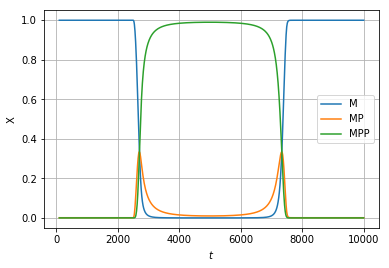

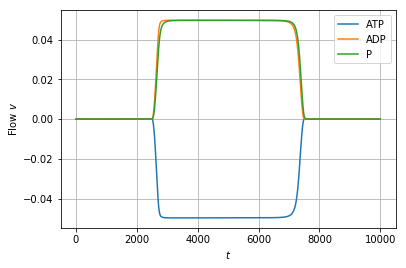

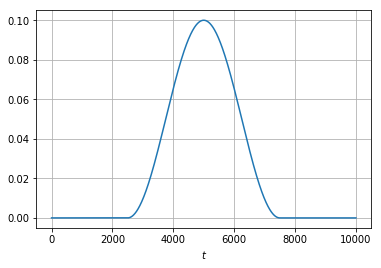

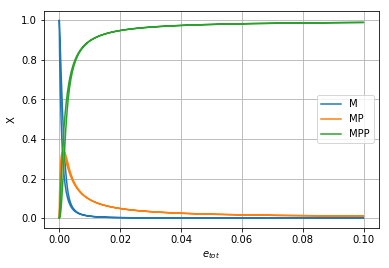

In [16]:
## Simulation

# Copy parameters and states to each sub module
# common = ['E1','M','MP','ATP','ADP','P','Aflow']


## Simulate
Dat = st.sim(S,sc=Sc,t=t,parameter=Parameter,V_flow=V_flow,quiet=quiet)

## Plot
Plot(S,Dat,M=['M','MP','MPP'],E=['E1','PD1__C1','PD2__C1'])


## Discussion
In a similar way to the PD module, the DPD module acts and a high-gain saturating amplifier, or switch <cite data-cite="BeaQia10"></cite>, with the total  enzyme  associated with the first reaction of the first PD $e_{tot}= x_{E1}+x_{c1}$ as the input and the amount of the double-phosphorylated protein MPP as output. Note that the gain is giher, and the behavior more switch-like compared to the PD module.

# MAPK cascade

## Create cascade from one PD and two DPD

In [17]:
def makeMAPK(sPD,S,Parameter,useDPD=True,quiet=quiet):
    """Create the MAPK cascade"""
   
    ## Components not to be renamed
    same = ['ATP','ADP','P']
    
    ## Amount of M in each layer
    X_M = np.array([1,7,50])
    X_E2 = 0.5*X_M

    ## Phosphorylation layer 1
    names = sPD['species'] + sPD['reaction']
    P1 = PD_abg.model()
    P1.name = 'P1'
    rename = copyNames(names,prefix='L1__',same=same, 
                       changed={'M':'MKKK','MP':'MKKKP','E1':'MKKKK'})
    mbg.rename(P1,rename,quiet=quiet)
    parameter_P1 = copyParameters(setParameterPD(s,x_M=X_M[0],x_E2=X_E2[0]),rename)
    
    if not useDPD:
        ## Use PD in place of DPD
        ## Phosphorylation layer 2
        names = sPD['species'] + sPD['reaction']
        P2 = PD_abg.model()
        P2.name = 'P2'
        rename = copyNames(names,prefix='L2__',same=same, 
                           changed={'M':'MKK','MP':'MKKP','E1':'MKKKP'})
        mbg.rename(P2,rename,quiet=quiet)
        parameter_P2 = copyParameters(setParameterPD(s,x_M=X_M[1],x_E2=X_E2[1]),rename)
        
        ## Phosphorylation layer 3
        P3 = PD_abg.model()
        P3.name = 'P3'
        rename = copyNames(names,prefix='L3__',same=same, 
                           changed={'M':'MK','MP':'MKP','E1':'MKKP'})
        mbg.rename(P3,rename,quiet=quiet)
        parameter_P3 = copyParameters(setParameterPD(s,x_M=X_M[2],x_E2=X_E2[2]),rename)
        
        connections = ['MKKKK','MKKKP','MKKP']
    else: 
    ## Use DPD 
        import DPD_abg
        ## Phosphorylation layer 2
        S,Sc,Parameter,sPD,sDPD = makeDPD(x_M=X_M[1],x_E2=X_E2[1],quiet=quiet)
        names = sDPD['species'] + sDPD['reaction']
        P2 = DPD_abg.model()
        P2.name = 'P2'
        rename = copyNames(names,prefix='L2__',same=same, 
                           changed={'M':'MKK','MP':'MKKP','MPP':'MKKPP','E1':'MKKKP'})
        mbg.rename(P2,rename,quiet=quiet)
        parameter_P2 = copyParameters(Parameter,rename)
        
        ## Phosphorylation layer 3
        S,Sc,Parameter,sPD,sDPD = makeDPD(x_M=X_M[2],x_E2=X_E2[2],quiet=quiet)
        names = sDPD['species'] + sDPD['reaction']
        print(names)
        P3 = DPD_abg.model()
        P3.name = 'P3'
        rename = copyNames(names,prefix='L3__',same=same, 
                           changed={'M':'MK','MP':'MKP','MPP':'MKPP','E1':'MKKPP'})
        mbg.rename(P3,rename,quiet=quiet)
        parameter_P3 = copyParameters(Parameter,rename)
        
        connections = ['MKKKK','MKKKP','MKKPP']
    
    ## Flowstat
    import AB_abg
    AB = AB_abg.model()
    mbg.rename(AB,{'A':'Aflow','B':'MKKKK'},quiet=quiet)
    
    ## Create the MAPK cascade with flowstat
    MAPK = bgt.new(name='MAPK')
    MAPK.add(AB,P1,P2,P3)
    unify = same + connections
    mbg.unify(MAPK,unify,quiet=quiet)
    
    parameter_P12 = mergeParameters(parameter_P1,parameter_P2)
    parameterM = mergeParameters(parameter_P12,parameter_P3)

    ## Stoichiometry
    sM = st.stoich(MAPK,quiet=quiet)
    chemostats = ['Aflow','ATP','ADP','P']
    scM = st.statify(sM,chemostats=chemostats)
    
    return sM,scM,parameterM

useDPD = True
sM,scM,ParameterM = makeMAPK(sPD,S,Parameter,useDPD=useDPD,quiet=True)

['PD1__C1', 'PD1__C2', 'PD1__E2', 'M', 'PD2__C1', 'PD2__C2', 'PD2__E2', 'MPP', 'E1', 'ATP', 'ADP', 'P', 'MP', 'PD1__r1', 'PD1__r2', 'PD1__r3', 'PD1__r4', 'PD2__r1', 'PD2__r2', 'PD2__r3', 'PD2__r4']


## Reactions, pathways and pools
The dot (.) notation is used to represent species and reactions within each submodule. Thus L2.PD1.C1 and L2.PD2.C2 represent the C2 species associated with each submodule within level 2 and L2.PD1.r1 and L2.PD2.r1  represent reaction r1 associated with each submodule within level 2.

1. There is a pathway though the four components r1-r4 within each of the five submodule
corresponding the the flow around the loop driven by the reaction
ATP = ADP + P.

2. Apart from the chemostats which are themselves conserved moieties, there are eight pools:

    a) C2 and E2 within each of the 5 submodules
 
    b) L1.C1 + L1.C2 + L2.PD1.C1 + L2.PD2.C1 + MKKK + MKKKP 
     
    c) L3.PD1.C1 + L3.PD1.C2 + L3.PD2.C1 + L3.PD2.C2 + MKPP + MKP + MK
    
    d) L2.PD1.C1 + L2.PD1.C2 + L2.PD2.C1 + L2.PD2.C2 + L3.PD1.C1 + L3.PD2.C1 + MKKPP + MKKP + MKK


### Reactions

In [18]:
disp.Latex(st.sprintrl(sM,chemformula = True))

<IPython.core.display.Latex object>

### Pathways

In [19]:
print(st.sprintp(scM))
sMp = st.path(sM,scM)
disp.Latex(st.sprintrl(sMp,chemformula = True))

5 pathways
0:  + L1.r1 + L1.r2 + L1.r3 + L1.r4
1:  + L2.PD1.r1 + L2.PD1.r2 + L2.PD1.r3 + L2.PD1.r4
2:  + L2.PD2.r1 + L2.PD2.r2 + L2.PD2.r3 + L2.PD2.r4
3:  + L3.PD1.r1 + L3.PD1.r2 + L3.PD1.r3 + L3.PD1.r4
4:  + L3.PD2.r1 + L3.PD2.r2 + L3.PD2.r3 + L3.PD2.r4



<IPython.core.display.Latex object>

### Pools

In [20]:
disp.Latex(st.sprintml(scM,chemformula=True))

<IPython.core.display.Latex object>

## Simulation

Unused parameters: ['X0_MP_']


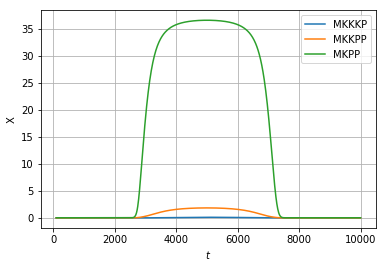

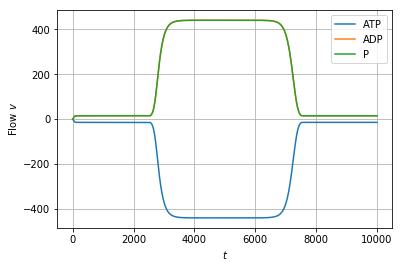

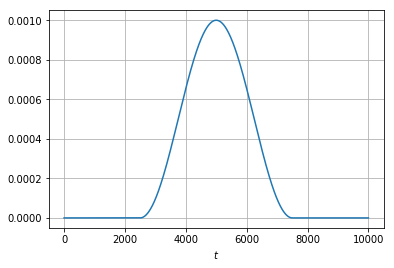

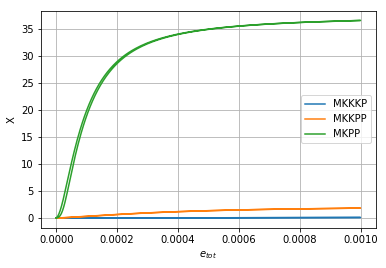

In [21]:
## Flows
e_max = 1e-3
V_flow = setFlow(e_max,t_max)

## Simulate
Dat = st.sim(sM,sc=scM,t=t,parameter=ParameterM,V_flow=V_flow,quiet=quiet)

## Plot
if useDPD:
    Plot(sM,Dat,M=['MKKKP','MKKPP','MKPP'],E=['MKKKK','L1__C1'])
else:
    Plot(sM,Dat,M=['MKKKP','MKKP','MKP'],E=['MKKKK','L1__C1'])


## Discussion
In a similar way to the PD and DPD modules, the MAPK cascade module acts and a high-gain saturating amplifier, or switch with the total  enzyme  associated with the first reaction of the PD $e_{tot}= x_{E1}+x_{c1}$ of the first layer as the input and the amount of the double-phosphorylated protein MKPP of the third layer as output. 
Here, the maximum value (0.001) of the input is 100 times smaller than that of the simulations of PD and DPD and so the gain is much higher, and the behavior more switch-like compared to the PD and DPD modules.